# Деревья решений 

## Данные
Данные о различных разновидностях пингвинов.
Задача: на основании представленных данных научиться предсказывать species

species: виды пингвинов (Chinstrap, Adélie, or Gentoo)

culmen_length_mm: длина клюва (mm)

culmen_depth_mm: ширина клюва (mm)

flipper_length_mm: длина плавника (mm)

body_mass_g: масса тела (g)

island: название острова (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)

sex: пол пингвина


## <font color='orange'>Загружаем библиотеки</font>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')

## <font color='orange'>Данные</font>

In [2]:
df = pd.read_csv('penguins_size.csv')

In [3]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
df['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

### <font color = 'green'>Предварительная обработка данных</font>

In [5]:
df.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


По сравнению собщим количеством данных - число отсутствующих невелико, поэтому можно как удалить их


In [7]:
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


Видим, что было удалено 10 строк, что говорит о том, что у нас было две строки, для которых отсутсвовали почти все данные

In [9]:
df['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [10]:
df['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

Видим наличие странного значения. Изучим подбронее эти строки

In [11]:
df[df['sex'] == '.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


Получили всего одну строку. Следует, что это проблема с заполнением данных
Попробуем не удалить, а предсказать пол по массе тела.

In [12]:
df[(df['species'] == 'Gentoo') & (df['sex'] == 'MALE')]['body_mass_g'].mean()

5484.836065573771

In [13]:
df[df['species'] == 'Gentoo'].groupby('sex').describe().transpose()

sex                           .       FEMALE         MALE
culmen_length_mm  count     1.0    58.000000    61.000000
                  mean     44.5    45.563793    49.473770
                  std       NaN     2.051247     2.720594
                  min      44.5    40.900000    44.400000
                  25%      44.5    43.850000    48.100000
                  50%      44.5    45.500000    49.500000
                  75%      44.5    46.875000    50.500000
                  max      44.5    50.500000    59.600000
culmen_depth_mm   count     1.0    58.000000    61.000000
                  mean     15.7    14.237931    15.718033
                  std       NaN     0.540249     0.741060
                  min      15.7    13.100000    14.100000
                  25%      15.7    13.800000    15.200000
                  50%      15.7    14.250000    15.700000
                  75%      15.7    14.600000    16.100000
                  max      15.7    15.500000    17.300000
flipper_length_mm count     1.0    58.000000    61.000000
                  mean    217.0   212.706897   221.540984
                  std       NaN     3.897856     5.673252
                  min     217.0   203.000000   208.000000
                  25%     217.0   210.000000   218.000000
                  50%     217.0   212.000000   221.000000
                  75%     217.0   215.000000   225.000000
                  max     217.0   222.000000   231.000000
body_mass_g       count     1.0    58.000000    61.000000
                  mean   4875.0  4679.741379  5484.836066
                  std       NaN   281.578294   313.158596
                  min    4875.0  3950.000000  4750.000000
                  25%    4875.0  4462.500000  5300.000000
                  50%    4875.0  4700.000000  5500.000000
                  75%    4875.0  4875.000000  5700.000000
                  max    4875.0  5200.000000  6300.000000

Путем анализа данных, мы можем извлечь значение строки, где значение sex соответствует точке. Затем, мы можем сравнить все характеристики средними значениями для мужского и женского пола. 

Видим, что Culmen length имеет среднее значение 44,5 см, близкое к женскому. При этом, стандартные отклонения как для мужского, так и для женского пола невелики, что указывает на небольшой разброс значений. 

Culmen depth, напротив, более соответствует среднему значению для мужского пола, при этом все значения мало отличаются от среднего значения. Однако видно, что данное значение близко к максимальному значений для женских осыбей. 

Значение flipper length находится посередине между средними значениями для женской и мужской особи, поэтому по нему сложно судить.

Значение body mass ближе к женской особи, однако видим, что значение близко к минимальному значению для мужских осыбей. Но здесь стоит отметить большой скачок между минимальным значением и 25%, что свидетельствует о единичных примерах с подобной массой.

Итак, после анализа всех признаков, можно предположить, что это вероятнее всего исследуемая осыбь принадлежит к  женскому роду.

In [14]:
df.at[336, 'sex'] = 'FEMALE'

In [15]:
#Проверка
df.loc[336]

species              Gentoo
island               Biscoe
culmen_length_mm       44.5
culmen_depth_mm        15.7
flipper_length_mm     217.0
body_mass_g          4875.0
sex                  FEMALE
Name: 336, dtype: object

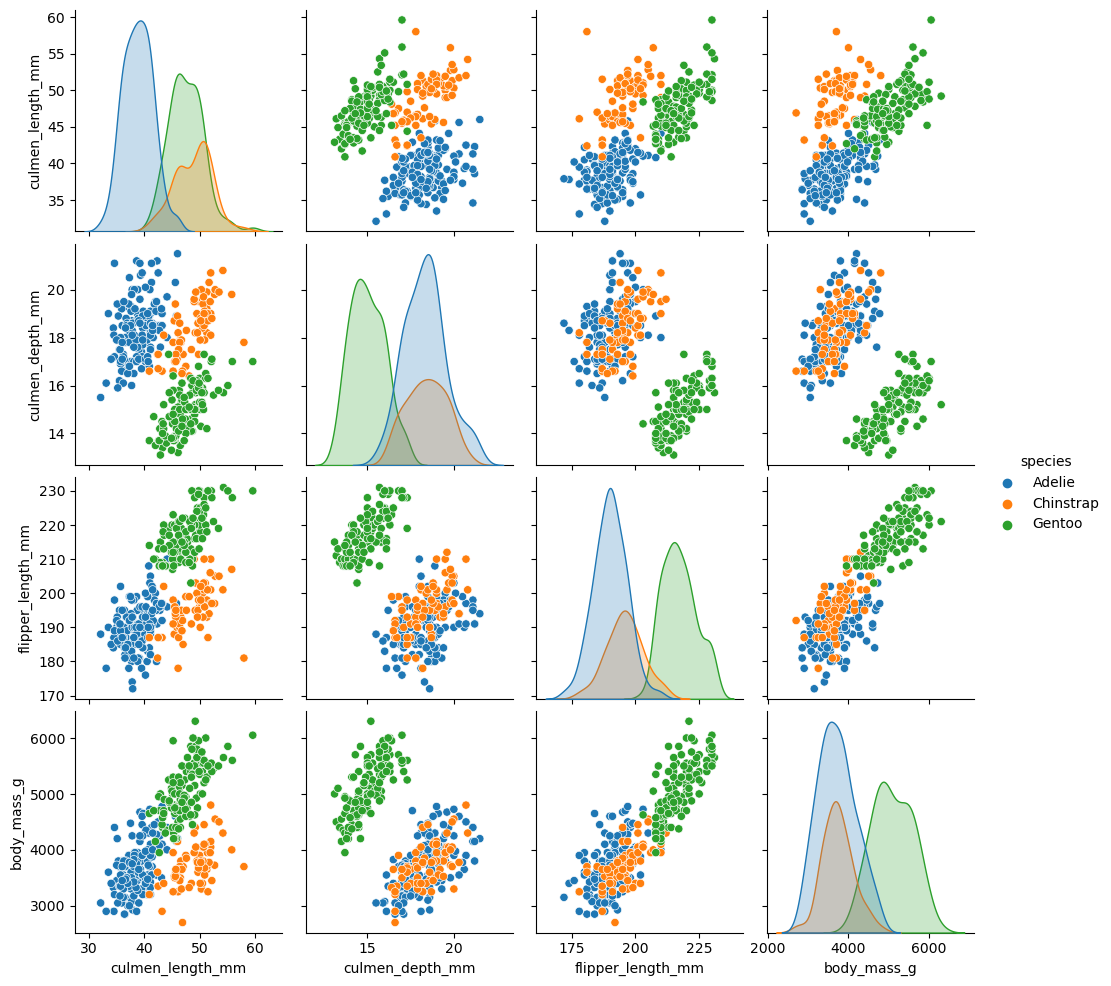

In [16]:
sns.pairplot(df, hue = 'species');

Видно, что для некоторых признаков виды пересекаются, а для некоторых хорошо разделимы, поэтому можно надеяться, что дерево решений сможет разделить

### <font color = 'green'>Создание модели</font>
Т
ак как деревья решений не поддерживают текстовые значения в качестве категориальных признаков, приведем их к дамми-формату

In [17]:
X = pd.get_dummies(df.drop('species', axis = 1), drop_first=True)

In [18]:
y = df['species']

В отличие от других алгоритмов машинного обучения в деревьях решений в корневом узде происходит следующее:

Мы будем выполнять сравнение по какому-то из признаков (равен или меньше либо равен). Это значит, что мы можем не выполнять масштабирование признаков, потому что мы не будем использовать несколько признаков одновременно. В каждм конкретном узле будет участвовать только конкретный признак.

В итоге можем пропустить шаг масштабирования

In [19]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## <font color = 'red'>Дерево решений</font>

 <font color='green'>Создание модели</font>


In [20]:
#Создаем параметры для перебора
max_depth = [2, 3, 4, 5]
max_leaf_nodes = [3, 4, 5, 6]
criterion=['gini', 'entropy']

#Создаем сетку
param_grid = {'max_depth' : max_depth,
             'max_leaf_nodes' : max_leaf_nodes,
             'criterion' : criterion}

#Создаем модель
model = DecisionTreeClassifier()

#Ищем оптимальные параметры по сетке
grid = GridSearchCV(model, param_grid)

#Обучаем модель
grid.fit(X_train, y_train)

#Выводим лучшие параметры
grid.best_params_


{'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 5}

In [21]:
#Создаем модель с оптимальными параметрами
model = DecisionTreeClassifier(criterion = 'entropy',
                            max_depth = 3,
                            max_leaf_nodes=5)
#Обучаем модель
model.fit(X_train, y_train)

#Запускаем модель на тестовых данных
base_preds = model.predict(X_test)

<font color = 'green'>Оценка модели</font>

In [22]:
print(classification_report(y_test, base_preds))

              precision    recall  f1-score   support

      Adelie       0.97      0.95      0.96        41
   Chinstrap       0.92      0.96      0.94        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.97       101
   macro avg       0.96      0.97      0.97       101
weighted avg       0.97      0.97      0.97       101



Видим что наша модель работает достаточно хорошо, видим хорошие значения precision, recall и accuracy. Это ожидаемо, так как еще на визуализации было видно хорошее разделение данных на отдельные классы.


In [23]:
confusion_matrix(y_test, base_preds)

array([[39,  2,  0],
       [ 1, 22,  0],
       [ 0,  0, 37]], dtype=int64)

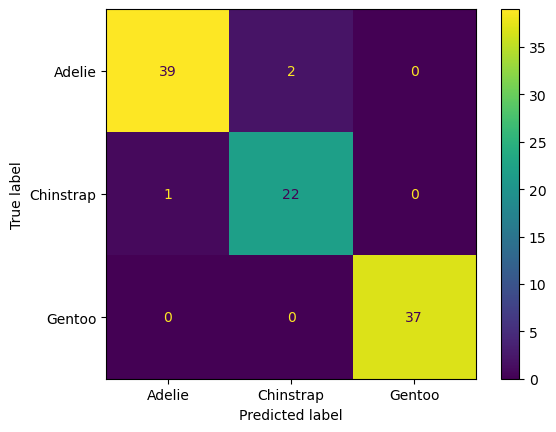

In [24]:
plot_confusion_matrix(model, X_test, y_test)

Видим, что неправильно классифицировано 3 пингвина 

<font color = 'green'>Интерпретация деревьев</font>

In [25]:
model.feature_importances_

array([0.2937869 , 0.06928567, 0.56250393, 0.        , 0.0744235 ,
       0.        , 0.        ])

Видим важность отдельных признаков, которые перечислены в том же порядке, что и наши признаки:

In [26]:
X.columns

Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'island_Dream', 'island_Torgersen', 'sex_MALE'],
      dtype='object')

Визуализируем в виде датафрейма

In [27]:
pd.DataFrame(index = X.columns, data = model.feature_importances_,
            columns = ['Важность признаков']).sort_values('Важность признаков')


,Важность признаков
body_mass_g,0.000000
island_Torgersen,0.000000
sex_MALE,0.000000
culmen_depth_mm,0.069286
island_Dream,0.074424
culmen_length_mm,0.293787
flipper_length_mm,0.562504


Видим, что наибольшую значимость имеет признак flipper_length_mm

<font color = 'green'> Визуализируем полученное дерево </font>

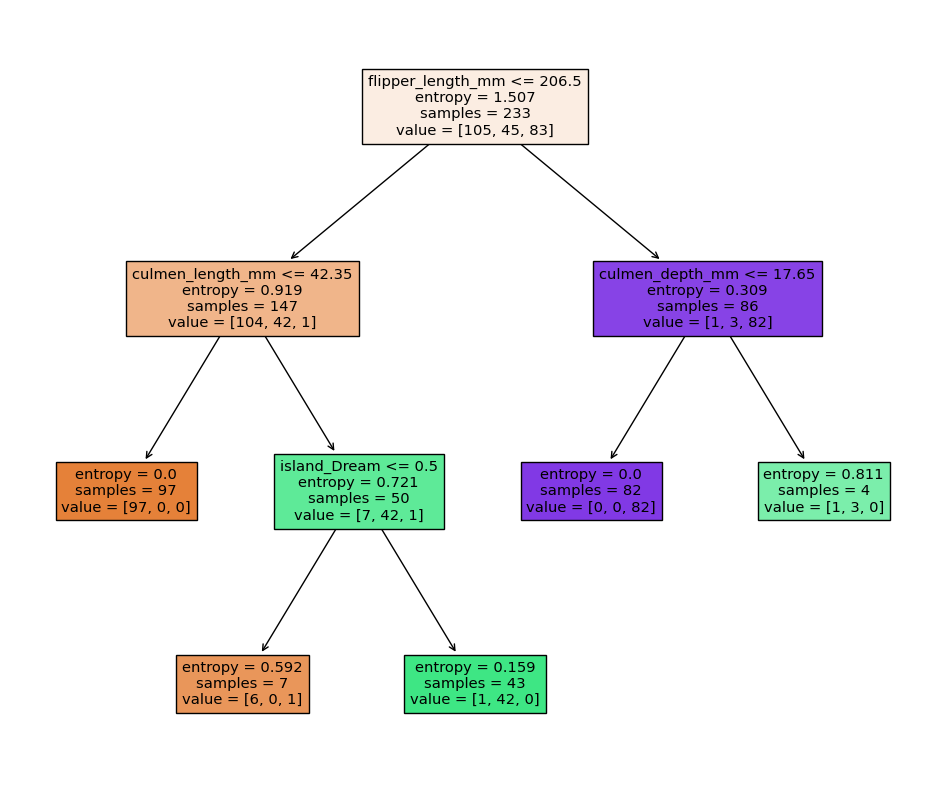

In [28]:
#чтобы видеть названия параметров в дереве решений
plt.figure(figsize = (12, 10))
plot_tree(model, feature_names = X.columns, 
         filled = True);

гиперпараметры деревьев решений
gini - значение джини импьюрити

samples - количество точек, которые пришло на вход в этот узел

value - список из 3х значений, сколько из точек принадлежит к каждому из 3х классов нашей целевой переменной

Узел раскрашивается тем цветом в зависимости от того, какие значения имеют наибольшее количество точек.
Более темный цвет означет большую однородность значений, когда подавляющее большинство точек принадлежит к какому-то одному классу. 

## <font color = 'red'>Случайный лес</font>

<font color = 'green'>Создание модели</font>

In [29]:
#Создаем параметры для перебора
n_estimators = [64, 100, 128, 200]
max_features = [2, 3, 4]
bootstrap = [True, False]
oob_score = [True, False]

#Создаем сетку
param_grid = {'n_estimators' : n_estimators,
             'max_features' : max_features,
             'bootstrap' : bootstrap,
             'oob_score' : oob_score}

#Создаем модель
model = RandomForestClassifier()

#Ищем оптимальные параметры по сетке
grid = GridSearchCV(model, param_grid)

#Обучаем модель
grid.fit(X_train, y_train)

#Выводим лучшие параметры
grid.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 64, 'oob_score': True}

In [30]:
#Создание модели
model = RandomForestClassifier(bootstrap='False', max_features= 2, 
                             n_estimators = 128,
                             oob_score = 'False',
                            random_state= 101)

#Обучение модели
model.fit(X_train, y_train)

#Запускаем модель на тестовых данных
preds = model.predict(X_test)

<font color = 'green'>Оценка работы модели</font>

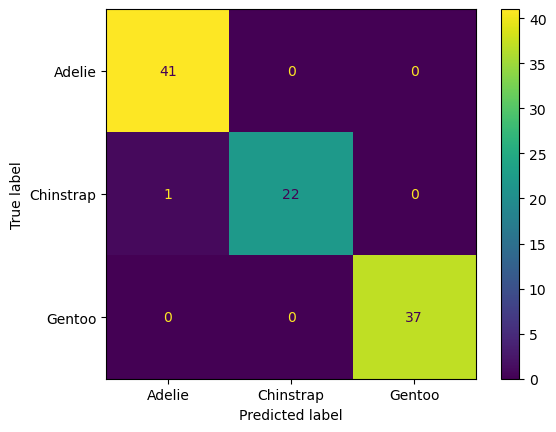

In [31]:
plot_confusion_matrix(model, X_test, y_test);

Снизили число неверно классифицированных пингвинов до 1.

In [32]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        41
   Chinstrap       1.00      0.96      0.98        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.99       101
   macro avg       0.99      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101



Значение характеристик precision, recall и accuracy также стали лучше


<font color = 'green'>Интерпретация модели</font>

In [33]:
pd.DataFrame(index = X.columns, data = model.feature_importances_,
            columns = ['Важность признаков']).sort_values('Важность признаков')

,Важность признаков
sex_MALE,0.008737
island_Torgersen,0.023984
island_Dream,0.101337
body_mass_g,0.140498
culmen_depth_mm,0.147162
flipper_length_mm,0.220466
culmen_length_mm,0.357816
